In [1]:
import pandas as pd
from numpy import random

from consts import default_random_seed
from sample_generation import create_sample, data_adjustments, \
    adjust_data_with_beta_estimations, simulate_counterfactuals
from strata import Strata
from zhang_rubin_help_func import calc_non_parametric_zhang_rubin, calc_zhang_rubin_bounds_analytically, plot_zhang_rubin_bounds_on_survivors, \
    calc_zhang_rubin_bounds_using_cvar_est, plot_zhang_rubin_bounds_no_x
random.seed(default_random_seed)

In [2]:
# rwd = data_adjustments(dataset='lalonde') # RWD = Real World Data set
rwd = data_adjustments(dataset='STAR') # RWD = Real World Data set

# $Y(t)|X,S_t=1$


In [3]:
# sample_for_y_dist = create_sample(
#     y0_dist_param ={'a0': 0.0, 'b0': 2.0, 'c0': 100.0, 'sigma_01': 1, 'sigma_00': 1} , 
#     y1_dist_param = {'a1': 0.0, 'b1': 4.0, 'c1': 100.0, 'sigma_11': 1, 'sigma_10': 1})

sample_for_y_dist = create_sample()
sample_for_y_dist_s = sample_for_y_dist.loc[sample_for_y_dist.D_obs==0] # survivers only


In [4]:
print("\nExample from each strata:")
display(sample_for_y_dist.groupby("stratum").sample(n=3, random_state=1))


Example from each strata:


,x,t,D0,D1,p_t0d0_x,p_t1d0_x,stratum,S1,S0,Y0,...,mu0,mu1,sigma_0,sigma_1,a0,b0,c0,a1,b1,c1
7918,-0.772476,0,0,0,0.941170,0.991612,AS,1.0,1.0,10.023207,...,8.455048,6.910096,1,1,0.0,2.0,10.0,0.0,4.0,10.0
4441,0.661246,0,0,0,0.792285,0.965735,AS,1.0,1.0,11.454635,...,11.322491,12.644982,1,1,0.0,2.0,10.0,0.0,4.0,10.0
7416,-0.390478,1,0,0,0.916098,0.987757,AS,1.0,1.0,10.409915,...,9.219044,8.438087,1,1,0.0,2.0,10.0,0.0,4.0,10.0
3417,0.308684,1,1,1,0.844397,0.975668,D,NaN,NaN,NaN,...,NaN,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
9948,0.022873,0,1,1,0.878375,0.981605,D,NaN,NaN,NaN,...,NaN,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
5502,-0.534283,0,1,1,0.926511,0.989379,D,NaN,NaN,NaN,...,NaN,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
1133,-0.559634,1,0,1,0.928218,0.989643,H,NaN,0.0,-0.318115,...,-1.119267,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
3691,0.049471,0,0,1,0.875504,0.981119,H,NaN,0.0,-0.175954,...,0.098943,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
9260,-0.092492,0,0,1,0.890171,0.983577,H,NaN,0.0,0.499586,...,-0.184985,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
7049,-0.025835,0,1,0,0.883483,0.982464,P,0.0,NaN,NaN,...,NaN,-0.103340,1,1,0.0,2.0,10.0,0.0,4.0,10.0


## Using observational data:
0.   Naive ATE
1.   Zhang & Rubin
2.   Using the parametric assumptions - Y is normal, estimate mu out of two mixed gaussians that differ by one latent variable

### 0. Naive ATE

##### Simulated Data

In [5]:
print(f"Naive ATE for Y: {round(sample_for_y_dist.Y1.mean() - sample_for_y_dist.Y0.mean(),2)}")
print(f"ATE for D: {round(sample_for_y_dist.D1.mean() - sample_for_y_dist.D0.mean(),2)}")

Naive ATE for Y: -1.05
ATE for D: -0.11


##### rwd

In [6]:
print(f"Naive ATE for Y: {round(rwd.loc[rwd.t==1].Y_obs.mean() - rwd.loc[rwd.t==0].Y_obs.mean(),2)}")
print(f"ATE for D: {round(rwd.loc[rwd.t==1].D_obs.mean() - rwd.loc[rwd.t==0].D_obs.mean(),2)}")

Naive ATE for Y: 0.07
ATE for D: -0.03


### 1. Zhang & Rubin

#### Non parametric

##### Simulated Data

In [7]:
zhang_rubin_lb, zhang_rubin_ub = calc_non_parametric_zhang_rubin(sample_for_y_dist)
print(f"Bounds by Zhang and Rubin: [{zhang_rubin_lb}, {zhang_rubin_ub}]")
as_df = sample_for_y_dist.loc[sample_for_y_dist.stratum==Strata.AS.name]
print(f"Actual AS treatment effect: {(as_df.Y1-as_df.Y0).mean()}")

Bounds by Zhang and Rubin: [-1.963831565780759, 0.2792491148288061]
Actual AS treatment effect: -0.09352604936304877


##### RWD = Real World Data set

In [8]:
zhang_rubin_lb_rwd, zhang_rubin_ub_rwd = calc_non_parametric_zhang_rubin(rwd)
print(f"Bounds by Zhang and Rubin: [{zhang_rubin_lb_rwd}, {zhang_rubin_ub_rwd}]")

Bounds by Zhang and Rubin: [-0.2959331517655422, 0.4347370777402621]


##### using CVaR

In [9]:
zhang_rubin_bounds_cvar = calc_zhang_rubin_bounds_using_cvar_est(sample_for_y_dist[['x','D_obs','Y_obs','t', 'p_t0d0_x', 'p_t1d0_x']])

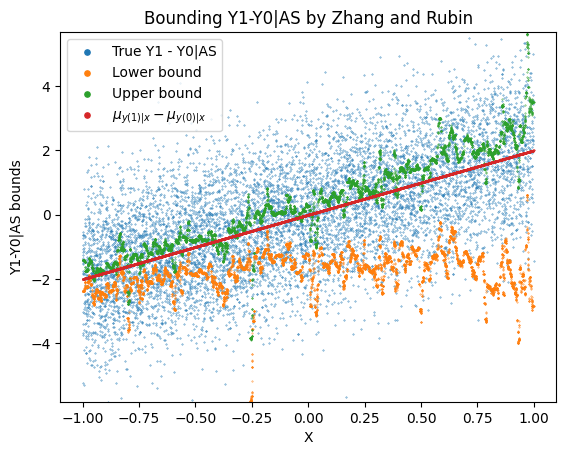

In [10]:
zr_bounds_cvar = plot_zhang_rubin_bounds_on_survivors(sample_for_y_dist_s, zhang_rubin_bounds_cvar)

###### Simulation


In [11]:
df_for_cvar_hat = adjust_data_with_beta_estimations(sample_for_y_dist)

beta_d_hat: [-1.95, -2.12, 0.94]
(True beta_d: [-2.0, -2.0, 1.0])


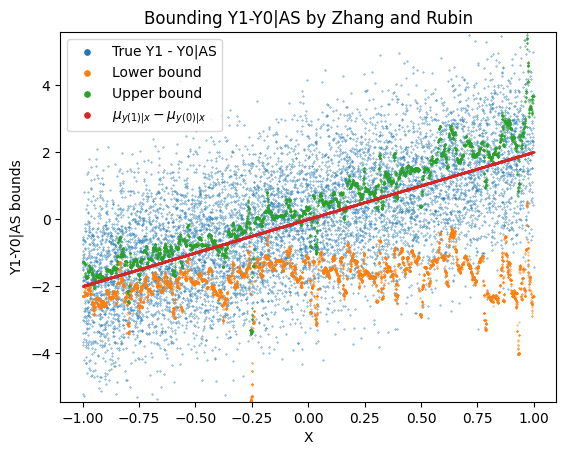

In [12]:
zhang_rubin_bounds_cvar_hat = calc_zhang_rubin_bounds_using_cvar_est(df_for_cvar_hat)
zr_bounds_cvar_hat = plot_zhang_rubin_bounds_on_survivors(sample_for_y_dist_s, zhang_rubin_bounds_cvar_hat)

###### RWD

In [13]:
df_for_cvar_hat_rwd = adjust_data_with_beta_estimations(rwd)

beta_d_hat: [0.34, -0.14, 0.37, -0.14, -0.16, -0.14, -0.34, -0.0, -0.02, 0.0]


In [14]:
zhang_rubin_bounds_cvar_hat_rwd = calc_zhang_rubin_bounds_using_cvar_est(df_for_cvar_hat_rwd)

In [15]:
# print(zhang_rubin_bounds_cvar_hat_rwd[0])

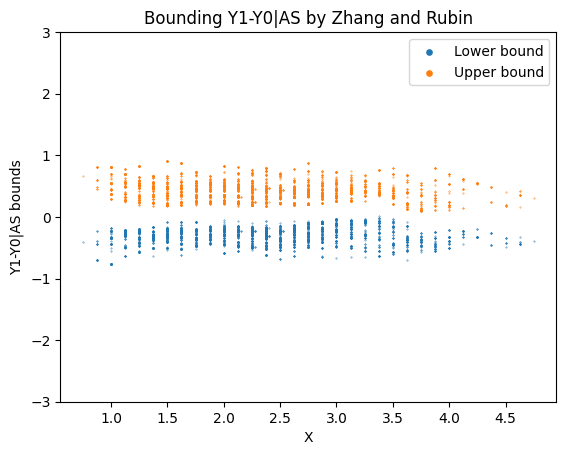

In [16]:
df_for_cvar_hat_rwd_s = df_for_cvar_hat_rwd.loc[df_for_cvar_hat_rwd.D_obs==0]
zr_bounds_cvar_hat_rwd = plot_zhang_rubin_bounds_on_survivors(df_for_cvar_hat_rwd_s, zhang_rubin_bounds_cvar_hat_rwd)

1 positive bounds (0.024%)
0 negative bounds (0.0%)


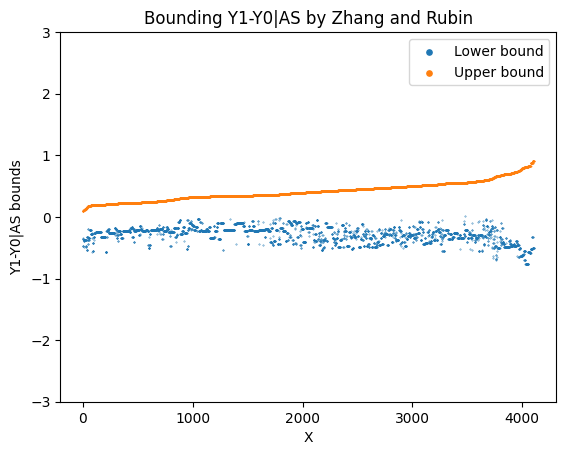

In [17]:
plot_zhang_rubin_bounds_no_x(zr_bounds_cvar_hat_rwd)

           counts  percentage
Strata.AS    2431   41.091954
Strata.H     1343   22.701149
Strata.P     1200   20.283976
Strata.D      942   15.922921


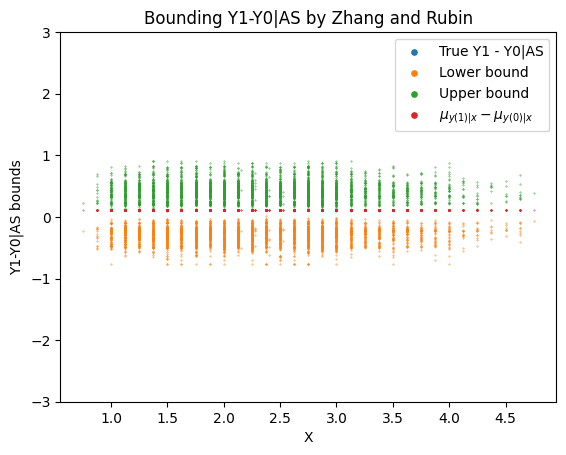

In [18]:
rwd_semi_simulated = simulate_counterfactuals(rwd)
rwd_semi_simulated_s = rwd_semi_simulated.loc[rwd_semi_simulated.D_obs==0]
zr_bounds_cvar_hat_rwd = plot_zhang_rubin_bounds_on_survivors(rwd_semi_simulated_s, zhang_rubin_bounds_cvar_hat_rwd)

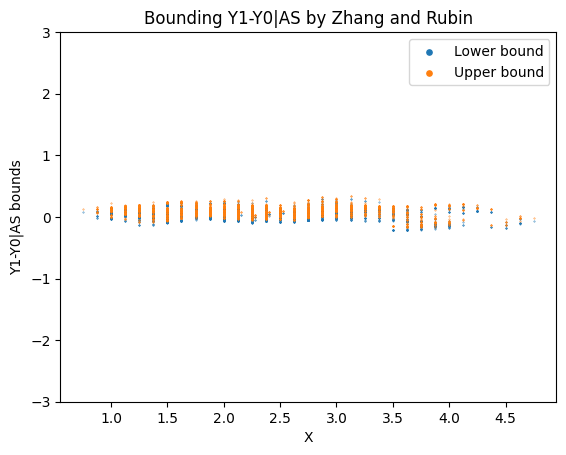

In [19]:
zhang_rubin_bounds_cvar_hat_rwd = calc_zhang_rubin_bounds_using_cvar_est(df_for_cvar_hat_rwd, monotonicity_assumption=True)
df_for_cvar_hat_rwd_s = df_for_cvar_hat_rwd.loc[df_for_cvar_hat_rwd.D_obs==0]
zr_bounds_cvar_hat_rwd = plot_zhang_rubin_bounds_on_survivors(df_for_cvar_hat_rwd_s, zhang_rubin_bounds_cvar_hat_rwd)

2947 positive bounds (71.773%)
428 negative bounds (10.424%)


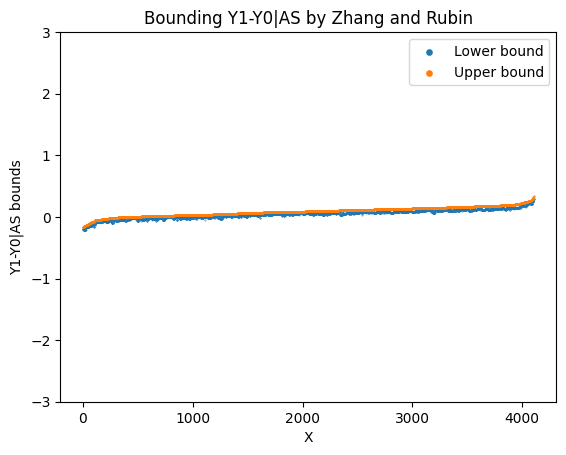

In [20]:
plot_zhang_rubin_bounds_no_x(zr_bounds_cvar_hat_rwd)

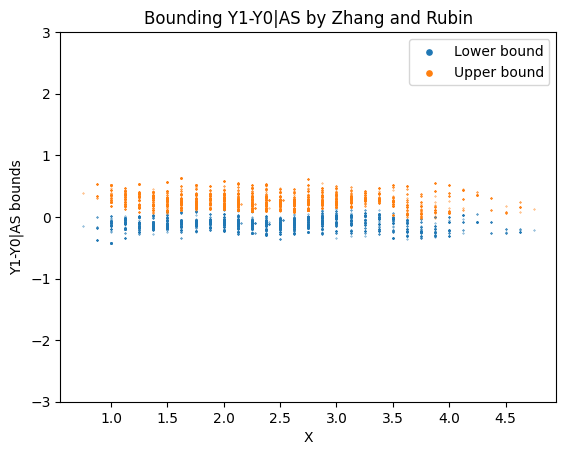

In [21]:
zhang_rubin_bounds_cvar_hat_rwd = calc_zhang_rubin_bounds_using_cvar_est(df_for_cvar_hat_rwd, ras_assumption=True)
df_for_cvar_hat_rwd_s = df_for_cvar_hat_rwd.loc[df_for_cvar_hat_rwd.D_obs==0]
zr_bounds_cvar_hat_rwd = plot_zhang_rubin_bounds_on_survivors(df_for_cvar_hat_rwd_s, zhang_rubin_bounds_cvar_hat_rwd)

405 positive bounds (9.864%)
6 negative bounds (0.146%)


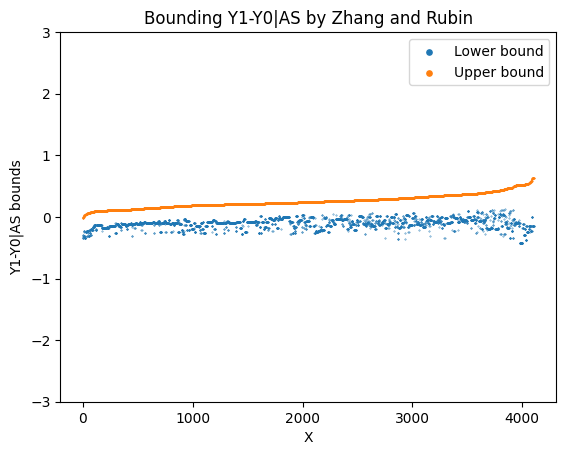

In [22]:
plot_zhang_rubin_bounds_no_x(zr_bounds_cvar_hat_rwd)

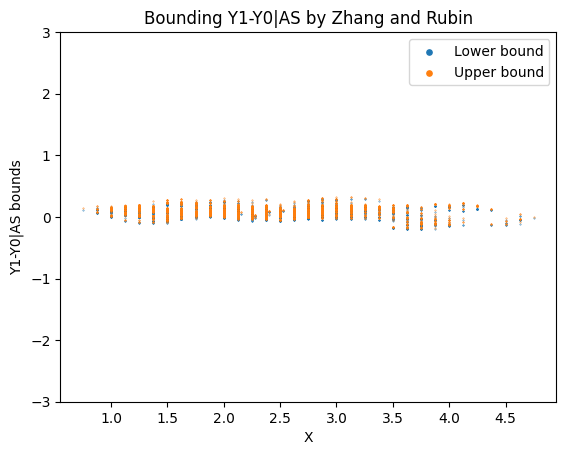

In [23]:
zhang_rubin_bounds_cvar_hat_rwd = calc_zhang_rubin_bounds_using_cvar_est(df_for_cvar_hat_rwd, monotonicity_assumption=True, ras_assumption=True)
df_for_cvar_hat_rwd_s = df_for_cvar_hat_rwd.loc[df_for_cvar_hat_rwd.D_obs==0]
zr_bounds_cvar_hat_rwd = plot_zhang_rubin_bounds_on_survivors(df_for_cvar_hat_rwd_s, zhang_rubin_bounds_cvar_hat_rwd)

3343 positive bounds (81.417%)
437 negative bounds (10.643%)


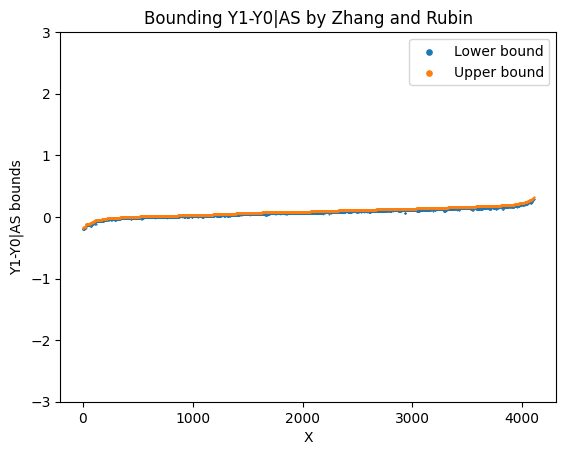

In [24]:
plot_zhang_rubin_bounds_no_x(zr_bounds_cvar_hat_rwd)

#### Parametric

Lower bound:
$min_{\pi_h}\left[ \bar{Y}^{obs}(1)_{\left[0,\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right]} - \bar{Y}^{obs}(0)_{\left[\frac{\pi_h}{P_{T=0,D=0}},1\right]} \right]$ <br>
Upper bound:
$max_{\pi_h}\left[ \bar{Y}^{obs}(1)_{\left[1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}},1\right]} - \bar{Y}^{obs}(0)_{\left[0,1-\frac{\pi_h}{P_{T=0,D=0}}\right]} \right]$

<br><br>


$\Rightarrow\bar{Y}^{obs}(1)_{\left[0,\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right]} \rightarrow
\frac{\pi_P}{\pi_{P}+\pi_{AS}}\cdot \frac{1}{\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}} \cdot
\int_{F_{Y_{(1)}}^{-1}(0)}^{F_{Y_{(1)}}^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)}
y\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{P}_{Y_{(1)}}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,\cdot dy
  + \frac{\pi_{AS}}{\pi_{P}+\pi_{AS}}\cdot \frac{1}{\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}} \cdot
  \int_{F_{Y_{(1)}}^{-1}(0)}^{F_{Y_{(1)}}^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)}
y\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{AS}_{Y_{(1)}}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,\cdot dy$

<br>

$\Rightarrow\bar{Y}^{obs}(1)_{\left[1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}},1\right]} \rightarrow
\frac{\pi_P}{\pi_{P}+\pi_{AS}}\cdot \frac{1}{\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}} \cdot
\int_{F_{Y_{(1)}}^{-1}\left(1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}}\right)}^{F_{Y_{(1)}}^{-1}(1)}
y\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{P}_{Y_{(1)}}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,\cdot dy
  + \frac{\pi_{AS}}{\pi_{P}+\pi_{AS}}\cdot \frac{1}{\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}} \cdot
  \int_{F_{Y_{(1)}}^{-1}\left(1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}}\right)}^{F_{Y_{(1)}}^{-1}(1)}
y\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{AS}_{Y_{(1)}}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,\cdot dy$
<br>
$\Rightarrow\bar{Y}^{obs}(0)_{\left[\frac{\pi_h}{P_{T=0,D=0}},1\right]} \rightarrow
\frac{\pi_H}{\pi_{H}+\pi_{AS}}\cdot \frac{1}{1-\frac{\pi_h}{P_{T=0,D=0}}} \cdot
\int_{F_{Y_{(0)}}^{-1}\left(\frac{\pi_h}{P_{T=0,D=0}}\right)}^{F_{Y_{(0)}}^{-1}(1)}
y\cdot\frac{1}{\sigma_{Y_{(0)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{H}_{Y_{(0)}}}{\sigma_{Y_{(0)}}}\right)^{\!2}\,\right)\,\cdot dy
  + \frac{\pi_{AS}}{\pi_{H}+\pi_{AS}}\cdot \frac{1}{1-\frac{\pi_h}{P_{T=0,D=0}}} \cdot
  \int_{F_{Y_{(0)}}^{-1}\left(\frac{\pi_h}{P_{T=0,D=0}}\right)}^{F_{Y_{(0)}}^{-1}(1)}
y\cdot\frac{1}{\sigma_{Y_{(0)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{AS}_{Y_{(0)}}}{\sigma_{Y_{(0)}}}\right)^{\!2}\,\right)\,\cdot dy$
<br>
$\Rightarrow\bar{Y}^{obs}(0)_{\left[0,1-\frac{\pi_h}{P_{T=0,D=0}}\right]} \rightarrow
\frac{\pi_H}{\pi_{H}+\pi_{AS}}\cdot \frac{1}{1-\frac{\pi_h}{P_{T=0,D=0}}}\cdot
\int_{F_{Y_{(0)}}^{-1}\left(0\right)}^{F_{Y_{(0)}}^{-1}\left(1-\frac{\pi_h}{P_{T=0,D=0}}\right)}
y\cdot\frac{1}{\sigma_{Y_{(0)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{H}_{Y_{(0)}}}{\sigma_{Y_{(0)}}}\right)^{\!2}\,\right)\,\cdot dy
  + \frac{\pi_{AS}}{\pi_{H}+\pi_{AS}}\cdot \frac{1}{1-\frac{\pi_h}{P_{T=0,D=0}}}\cdot
  \int_{F_{Y_{(0)}}^{-1}\left(0\right)}^{F_{Y_{(0)}}^{-1}\left(1-\frac{\pi_h}{P_{T=0,D=0}}\right)}
y\cdot\frac{1}{\sigma_{Y_{(0)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{AS}_{Y_{(0)}}}{\sigma_{Y_{(0)}}}\right)^{\!2}\,\right)\,\cdot dy$

Note that the weights are identifiable from observational data:
$\frac{\pi_{P}}{\pi_{P}+\pi_{AS}}=\left(1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}}\right)$ <br>
$\frac{\pi_{H}}{\pi_{H}+\pi_{AS}}=\left(\frac{\pi_h}{P_{T=0,D=0}}\right)$

<br>
$F_{Y_{(1)}}^{-1}(\alpha)=P(Y_{(1)}<F^{-1}(\alpha))$ where $F^{-1}(\alpha)$ is the $\alpha$ quantile of $Y_{(1)}$. Although quantile function for mixed Gaussians does not admit a closed-form expression, it can be calculated. First we'll calculate the quantile using binary search, and then we'll calculate the cdf of that quantile.

##### For 40 samples, plot $\pi_h$, parametric bounds for each $\pi_h$, final parametric and non parametric bounds

In [25]:
# pi_h_and_bounds_plots_controller(sample_for_y_dist)

TODO - Note that some pi's don't have the integral solution <br>
TODO - check the $\mu$ inside the integral vs outside, should be the same (for given bounds)<br>

In [26]:
zhang_rubin_bounds_analytic = calc_zhang_rubin_bounds_analytically(sample_for_y_dist_s)

row 0 out of 9238
row 1000 out of 9238
row 2000 out of 9238
row 3000 out of 9238
row 4000 out of 9238
row 5000 out of 9238
row 6000 out of 9238
row 7000 out of 9238
row 8000 out of 9238
row 9000 out of 9238


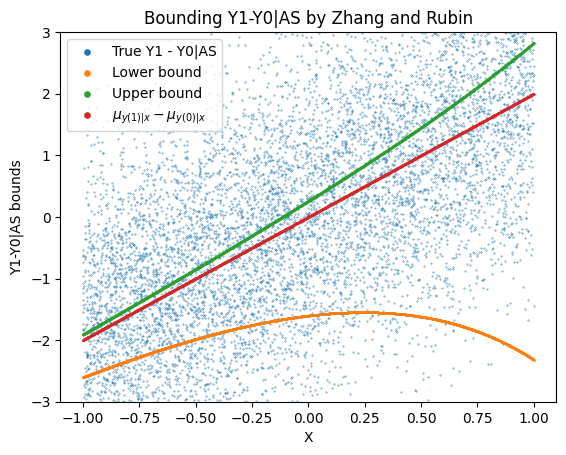

In [27]:
zr_bounds_analytic = plot_zhang_rubin_bounds_on_survivors(sample_for_y_dist_s, zhang_rubin_bounds_analytic)

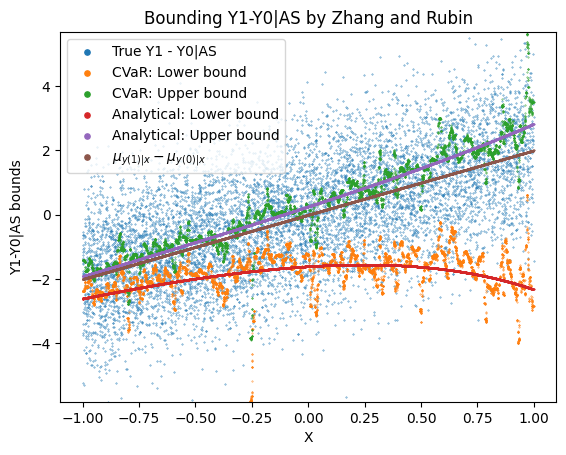

In [28]:
import matplotlib.pyplot as plt

df_plot_as = sample_for_y_dist_s.loc[sample_for_y_dist_s.stratum == Strata.AS.name]
plt.scatter(df_plot_as.x, (df_plot_as.Y1 - df_plot_as.Y0), label="True Y1 - Y0|AS", s=0.1)

plt.scatter(list(zr_bounds_cvar['x']), zr_bounds_cvar['lb'], label="CVaR: Lower bound", s=0.1)
plt.scatter(list(zr_bounds_cvar['x']), zr_bounds_cvar['up'], label="CVaR: Upper bound", s=0.1)

plt.scatter(list(zr_bounds_analytic['x']), zr_bounds_analytic['lb'], label="Analytical: Lower bound", s=0.1)
plt.scatter(list(zr_bounds_analytic['x']), zr_bounds_analytic['up'], label="Analytical: Upper bound", s=0.1)
plt.scatter(list(zr_bounds_analytic['x']), zr_bounds_analytic['true value'], label=r'$\mu_{y(1)|x}-\mu_{y(0)|x}$', s=0.1)

plt.legend(markerscale=12)
# plt.legend()
plt.title("Bounding Y1-Y0|AS by Zhang and Rubin")
plt.xlabel('X')
plt.ylabel('Y1-Y0|AS bounds')
plt.ylim((min(-3, min(min(zr_bounds_cvar['lb']), min(zr_bounds_analytic['lb']))), max(3, max(max(zr_bounds_cvar['up']), max(zr_bounds_analytic['up'])))))
plt.show()